In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import pygame
import random
from collections import deque



# Get device
CPU or GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Create environment
The Schedule needs an environment, lets create it

In [3]:
#Create a class for the schedule problem using the gym interface
class ScheduleGym():
    def __init__(self, num_days, num_hours, num_classes, num_subjects, verbose=False):
        self.num_days = num_days
        self.num_hours = num_hours
        self.num_classes = num_classes
        self.num_subjects = num_subjects
        self.num_slots = num_days * num_hours
        self.target_hours = np.zeros((num_classes, num_subjects), dtype=int) # Target hours for each class and subject
        self.schedule = -1*np.ones((num_classes, num_days, num_hours), dtype=int) # Schedule for each class, -1 means no subject assigned
        self.num_actions_left = 1000 #Number of actions left to take
        self.verbose = verbose #Debug on or off
        #This is to go from a one dimensional action space to a 4 dimensional action space
        #class_id, day, hour, subject_id
        self.max_values = np.array([num_classes, num_days, num_hours, num_subjects])
        self.cumprod_max_values = np.cumprod(self.max_values[::-1])[::-1]
        # self.decoder_base = np.cumprod(self.max_values)
        # self.encoder_base = np.flip(np.cumprod(np.flip(self.max_values)))
        self.initial_hours_to_assign = 0 #How many hours we have initially to assign, used to calculate score later

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        for class_id in range(self.num_classes):
            for subject_id in range(self.num_subjects):
                self.target_hours[class_id, subject_id] = np.random.randint(1, 5)
        
        self.initial_hours_to_assign = self.target_hours.sum().sum()

        self.schedule = -1*np.ones((self.num_classes, self.num_days, self.num_hours), dtype=int) # Schedule for each class, -1 means no subject assigned
        self.num_actions_left = self.initial_hours_to_assign * 10 #Optimally we would need to take number of hours to assign steps to complete the schedule, lets give it some wiggle room
        
        #Return the current state,info
        info = {}
        #return (self.target_hours, self.schedule), info
        return self.state2vector(), info
    
    def state2vector(self):
        #Convert the state to a vector
        return np.concatenate([self.target_hours.flatten(), self.schedule.flatten()])/(self.initial_hours_to_assign * 10.0 + 1.0)
    
    def render(self):
        #Print the schedule
        for class_id in range(self.num_classes):
            print(f"Class {class_id + 1}:")
            for day in range(self.num_days):
                print(f"Day {day + 1}: {self.schedule[class_id, day]}")
            print()
        print(f'Fitness: {self.fitness()}, Actions left: {self.num_actions_left}')

        #print the target hours
        print("Target Hours:")
        for class_id in range(self.num_classes):
            print(f"Class {class_id + 1}: {self.target_hours[class_id]}")



    def decode_action(self, actions):
        actions = np.array(actions).reshape(-1) # Ensure numbers is a 1D column array
        aAll = np.zeros((actions.shape[0], len(self.max_values)), dtype=int)
        for i in range(len(self.max_values) - 1):
            aAll[:, i] = actions // self.cumprod_max_values[i+1]
            actions -= aAll[:, i]*self.cumprod_max_values[i+1]
        aAll[:,-1] = actions
        
        return aAll
    
    # Go from a 4D action to a 1D action
    def encode_action(self, actions):
        number = np.zeros(actions.shape[0], dtype=int)
        for i in range(len(self.max_values) - 1):
            number += actions[:,i]*self.cumprod_max_values[i+1]
        number += actions[:,-1]
        
        return number

            
    #next_state, reward, done, truncated, info = env.step(action)
    # def step(self, action):
    #     # Update the schedule based on the action

    #     #Check if the action is a tuple or a single value
    #     if isinstance(action, tuple):
    #         #We are already in the decoded format
    #         class_id, day, hour, subject_id = action
    #     elif isinstance(action, np.ndarray):
    #         class_id = action[0]
    #         day = action[1]
    #         hour= action[2]
    #         subject_id = action[3]
    #     else:
    #         #Need to go from 1D to 4D
    #         decoded = self.decode_action(action).squeeze()
    #         class_id = decoded[0]
    #         day = decoded[1]
    #         hour= decoded[2]
    #         subject_id = decoded[3]

         
    #     #If subject_id is >= num_subjects then this is a remove action for the class_id, day, hour slot
    #     #If the slot is already occupied, then the old subject will be placed back into the target hours
        
    #     current_subject_id = self.schedule[class_id, day, hour]

    #     if self.verbose:
    #         print('Before action:')
    #         for class_id in range(self.num_classes):
    #             print(f"Class {class_id + 1}: {self.target_hours[class_id]}")
 
    #     #The slot was already booked, lets reomove it (and all of its dependencies)
    #     result = "N/A"
    #     reward = 0
    #     if current_subject_id != -1:
    #         self.schedule[class_id, day, hour] = -1
    #         self.target_hours[class_id, current_subject_id] += 1
    #         result = "Removed"
    #         reward = -0.16 #Penalty for removing a subject

        
    #     #See if it is an add action
    #     elif subject_id < self.num_subjects:
    #         #Yes its an add action, lets see if we have enough hours to actually add it
    #         if self.target_hours[class_id, subject_id] > 0:
    #             self.schedule[class_id, day, hour] = subject_id
    #             self.target_hours[class_id, subject_id] -= 1
    #             result = "Added"
    #             reward = 0.15 #Reward for adding a subject
    #         else:
    #             #We are trying to add a subject that is already empty
    #             reward = -0.25 #Penalty for invalid action    
    #     else:
    #         #We are trying to remove a subject that is not in the schedule, this is an invalid action
    #         reward = -0.5 #Penalty for invalid action
        
    #     self.num_actions_left -= 1
    #     done = self.is_done()  
    #     if done:
    #         reward += 1.0
    #         reward += self.fitness()  #If we are done we get the full score of the schedule
        
    #     if self.verbose:
    #         print(f"Action: {action}, Class: {class_id}, Subject: {subject_id}, Day: {day}, Hour: {hour}, , current_subject_id: {current_subject_id}, Result: {result}, reward: {reward}, done: {done}")     
    #         print('After action:')
    #         for class_id in range(self.num_classes):
    #             print(f"Class {class_id + 1}: {self.target_hours[class_id]}")

    #         if done:
    #             print('Final schedule:')
    #             self.render()
                
    #     truncated, info = False, {} #To be implemented later if needed
    #     #Return the next state, reward, done, truncated and info
    #     #return (self.target_hours, self.schedule), reward, done, truncated, info
    #     return self.state2vector(), reward, done, truncated, info
    
    def step(self, action):
        # Update the schedule based on the action

        #Check if the action is a tuple or a single value
        if isinstance(action, tuple):
            #We are already in the decoded format
            class_id, day, hour, subject_id = action
        elif isinstance(action, np.ndarray):
            class_id = action[0]
            day = action[1]
            hour= action[2]
            subject_id = action[3]
        else:
            #Need to go from 1D to 4D
            decoded = self.decode_action(action).squeeze()
            class_id = decoded[0]
            day = decoded[1]
            hour= decoded[2]
            subject_id = decoded[3]

         
        #If subject_id is >= num_subjects then this is a remove action for the class_id, day, hour slot
        #If the slot is already occupied, then the old subject will be placed back into the target hours
        
        current_subject_id = self.schedule[class_id, day, hour]

        if self.verbose:
            print('Before action:')
            for class_id in range(self.num_classes):
                print(f"Class {class_id + 1}: {self.target_hours[class_id]}")
 
        #The slot was already booked, lets reomove it (and all of its dependencies)
        result = "N/A"
        reward = 0
        if current_subject_id != -1:
            self.schedule[class_id, day, hour] = -1
            self.target_hours[class_id, current_subject_id] += 1
            result = "Removed"
            reward = -0.12 #Penalty for removing a subject

        
        #See if it is an add action
        elif subject_id < self.num_subjects:
            #Yes its an add action, lets see if we have enough hours to actually add it
            if self.target_hours[class_id, subject_id] > 0:
                self.schedule[class_id, day, hour] = subject_id
                self.target_hours[class_id, subject_id] -= 1
                result = "Added"
                reward = 0.1 #Reward for adding a subject
            else:
                #We are trying to add a subject that is already empty
                reward = -0.15 #Penalty for invalid action    
        else:
            #We are trying to remove a subject that is not in the schedule, this is an invalid action
            reward = -0.15 #Penalty for invalid action
        
            # Reward for completing a subject's required hours
        if self.target_hours[class_id, subject_id] == 0:
            reward += 0.2

        completion_percentage = 1.0 - (self.target_hours.sum() / self.initial_hours_to_assign)
        reward += completion_percentage * 0.1 

        self.num_actions_left -= 1
        done = self.is_done()  
        if done:
            reward += 1.0
            reward += self.fitness()  #If we are done we get the full score of the schedule
        
  

        if self.verbose:
            print(f"Action: {action}, Class: {class_id}, Subject: {subject_id}, Day: {day}, Hour: {hour}, , current_subject_id: {current_subject_id}, Result: {result}, reward: {reward}, done: {done}")     
            print('After action:')
            for class_id in range(self.num_classes):
                print(f"Class {class_id + 1}: {self.target_hours[class_id]}")

            if done:
                print('Final schedule:')
                self.render()
                
        truncated, info = False, {} #To be implemented later if needed
        #Return the next state, reward, done, truncated and info
        #return (self.target_hours, self.schedule), reward, done, truncated, info
        return self.state2vector(), reward, done, truncated, info       


    def is_done(self):
        #Check if the schedule is complete
        return np.all(self.target_hours == 0) or self.num_actions_left <= 0
    
    def get_action_sizes(self):
        #Return the sizes of the action space
        return [self.num_classes, self.num_days, self.num_hours, self.num_subjects]
        #return np.prod(self.max_values)
    
    def get_state_sizes(self):
        #Return the shapes of the state space
        #return self.target_hours.shape, self.schedule.shape
        return self.state2vector().shape

    
    def fitness(self):
        #Calculate the fitness of the schedule
        #fitness = self.num_actions_left * 0.001 #We want to maximize the number of actions left
        fitness = 0.0
        # target hours remaining
        target_hours_remaining = self.target_hours.sum().sum()

        fitness -= target_hours_remaining * 1

        # Count the number of holes in the schedule, that is where no subject is assigned, but is surrounded by subjects
        # If there are no subjects assigned to the edges, that is not considered a hole
        num_holes = 0

        # Create shifted versions of the schedule to compare adjacent hours
        left_shifted = np.roll(self.schedule, shift=-1, axis=2)
        right_shifted = np.roll(self.schedule, shift=1, axis=2)

        # Identify holes: -1 in the current schedule, and not -1 in both the left and right shifted schedules
        # Avoid considering the edges by setting the comparison for the first and last hour to False
        holes = (self.schedule == -1) & (left_shifted != -1) & (right_shifted != -1)
        holes[:, :, 0] = False  # Ignore first hour edge cases
        holes[:, :, -1] = False  # Ignore last hour edge cases

        # Count the number of holes
        num_holes = np.sum(holes)

        fitness -= num_holes * 0.15

        #return -fitness #Swapped fitness now....

        fitness *= 4.2 #
        return fitness


# Create an agent that can do scheduling
The agent is of type Actor Critic

In [4]:

# class ScheduleAgent(nn.Module):
#     def __init__(self, state_size, action_sizes, hidden_dim=256, gamma=0.99):
#         super().__init__()
        
#         self.action_sizes = action_sizes
#         self.gamma = gamma
        
#         self.shared = nn.Sequential(
#             nn.Linear(state_size, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU()
#         )
        
#         self.actor_heads = nn.ModuleList([nn.Linear(hidden_dim, dim) for dim in action_sizes])
        
#         self.critic = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1)
#         )
        
#     def forward(self, state):
#         #Go through the shared layers
#         shared_output = self.shared(state)
        
#         #Each head predicts its own action, like Class, Day, Hour, Subject etc
#         action_probs = [torch.softmax(head(shared_output), dim=-1) for head in self.actor_heads]

#         #The critic predicts the value of the state
#         state_value = self.critic(shared_output)
        
#         return action_probs, state_value
    
#     def choose_action(self, state):
#         #device = next(self.parameters()).device
#         #state = torch.FloatTensor(state).unsqueeze(0).to(device)
       
#         #Get the probabilities of the actions for each head
#         with torch.no_grad():
#             action_probs, _ = self.forward(state)
        
#         #Choose an action for each head
#         #actions = [torch.multinomial(probs, 1).item() for probs in action_probs]
#         #actions = torch.stack([torch.multinomial(probs, 1) for probs in action_probs]).squeeze(-1)
#         actions = torch.tensor([torch.multinomial(probs[0], 1).item() for probs in action_probs], device=state.device)

#         return actions
    
    



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScheduleAgent(nn.Module):
    def __init__(self, state_size, action_sizes, hidden_dim=256, gamma=0.99):
        super().__init__()
        
        self.action_sizes = action_sizes
        self.gamma = gamma
        
        self.shared = nn.Sequential(
            nn.Linear(state_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.actor_heads = nn.ModuleList([nn.Linear(hidden_dim, dim) for dim in action_sizes])
        
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        shared_output = self.shared(state)
        
        action_probs = [F.softmax(head(shared_output), dim=-1) for head in self.actor_heads]
        state_value = self.critic(shared_output)
        
        return action_probs, state_value
    
    def choose_action(self, state):
        with torch.no_grad():
            action_probs, _ = self.forward(state)
        
        actions = torch.tensor([torch.multinomial(probs[0], 1).item() for probs in action_probs], device=state.device)
        return actions
    
    def get_value(self, state):
        _, state_value = self.forward(state)
        return state_value

    def evaluate_actions(self, states, actions):
        action_probs, state_values = self.forward(states)
        action_log_probs = sum([torch.log(probs[torch.arange(probs.size(0)), action]) 
                                for probs, action in zip(action_probs, actions.T)])
        return action_log_probs, state_values



# Create environment

In [6]:
env = ScheduleGym(num_days=2, num_hours=4, num_classes=1, num_subjects=2)
state_dim = env.get_state_sizes()[0]
action_dims = env.get_action_sizes()

# Create Agent

In [7]:
agent = ScheduleAgent(state_dim, action_dims, hidden_dim=2048)

In [8]:
x,_ = env.reset()
x.shape

(10,)

In [9]:
ost = agent(torch.FloatTensor(x))

In [10]:
ost2 = agent.choose_action(torch.FloatTensor(x).unsqueeze(0))

In [11]:
ost2

tensor([0, 0, 1, 1])

In [12]:
type(ost2)


torch.Tensor

# Create optimizer

In [13]:
#Send the agent to the correct device
agent.to(device)

ScheduleAgent(
  (shared): Sequential(
    (0): Linear(in_features=10, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
  )
  (actor_heads): ModuleList(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Linear(in_features=2048, out_features=2, bias=True)
    (2): Linear(in_features=2048, out_features=4, bias=True)
    (3): Linear(in_features=2048, out_features=2, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [14]:
optimizer = optim.Adam(agent.parameters(), lr=3e-4)

In [15]:

# num_episodes = 10
# gamma = 0.99

# end_rewards = []
# total_rewards = []
# num_actions_per_episode = []

# for episode in range(num_episodes):
#     state, _ = env.reset()
#     state = torch.FloatTensor(state).unsqueeze(0).to(device)
#     done = False
#     episode_reward = 0.0
#     episode_counter = 0
    
#     while not done:
#         actions = agent.choose_action(state)
#         actions_np = actions.cpu().numpy()
#         next_state, reward, done , _, _ = env.step(actions_np)
        
#         #state = torch.FloatTensor(state).unsqueeze(0).to(device)
#         next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
#         reward = torch.FloatTensor([reward]).unsqueeze(0).to(device)
#         done = torch.FloatTensor([int(done)]).unsqueeze(0).to(device)
        
#         action_probs, state_value = agent(state)
#         _, next_state_value = agent(next_state)
        
#         td_error = reward + gamma * next_state_value * (1 - done) - state_value
        
#         actor_loss = -(1 / len(action_probs)) * sum(torch.log(probs[0, action]) for probs, action in zip(action_probs, actions)) * td_error.detach()
#         #actor_loss = -(1 / len(action_probs)) * torch.sum(torch.log(action_probs[torch.arange(len(actions)), actions])) * td_error.detach()
#         critic_loss = td_error.pow(2)
        
#         loss = actor_loss + critic_loss
        
#         optimizer.zero_grad()
#         loss.mean().backward()
#         optimizer.step()
        
#         state = next_state
#         episode_reward += reward
#         episode_counter += 1

#     end_reward = env.fitness()
#     end_rewards.append(end_reward)
#     total_rewards.append(episode_reward)
#     num_actions_per_episode.append(episode_counter)
    
#     if episode % 100 == 0:
#         print(f"Episode {episode}, Reward: {episode_reward}")

# print("Final schedule:")
# env.render()

In [16]:
# Training loop
num_episodes = 10000
gamma = 0.99
end_rewards = []
total_rewards = []
num_actions_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset(seed=42)
    #env.render() #Debug
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    done = False
    episode_reward = 0.0
    episode_counter = 0
    
    states, actions, rewards, next_states, dones = [], [], [], [], []
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _, _ = env.step(action.cpu().numpy())
        
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        reward = torch.FloatTensor([reward]).unsqueeze(0).to(device)
        done = torch.FloatTensor([int(done)]).unsqueeze(0).to(device)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
        
        state = next_state
        episode_reward += reward.item()
        episode_counter += 1
        #print(f't:{episode_counter} Actions: {action} reward: {reward.item()} total_reward: {episode_reward}')
    
    # Convert lists to tensors
    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)
    dones = torch.cat(dones)
    
    # Compute returns and advantages
    returns = []
    R = 0
    for reward, done in zip(reversed(rewards.cpu().numpy()), reversed(dones.cpu().numpy())):
        R = reward + gamma * R * (1 - done)
        returns.insert(0, R)
    returns = torch.FloatTensor(returns).to(device)

    state_values = agent.get_value(states).squeeze()  # Ensure it's 1D
    next_state_values = agent.get_value(next_states).squeeze()  # Ensure it's 1D

    # Ensure returns has the same shape as state_values
    returns = returns.view_as(state_values)

    td_errors = rewards.squeeze() + gamma * next_state_values * (1 - dones.squeeze()) - state_values
    advantages = td_errors.detach()

    # Compute losses
    action_log_probs, _ = agent.evaluate_actions(states, actions)
    actor_loss = -(action_log_probs * advantages).mean()
    critic_loss = F.mse_loss(state_values, returns)

    loss = actor_loss + 0.5 * critic_loss
        
    # Perform the update
    optimizer.zero_grad()
    loss.backward()
    #print the gradients
    if True:
        for param in agent.parameters():
            print(param.grad.data.sum())

    break
    #Clip the gradients
    torch.nn.utils.clip_grad_norm_(agent.parameters(), 1.0)
    optimizer.step()

    end_reward = env.fitness()
    end_rewards.append(end_reward)
    total_rewards.append(episode_reward)
    num_actions_per_episode.append(episode_counter)

    #Debug
    #print('End result:')
    #env.render()
    # if episode_reward > 2.051:
    #     print('wtf')
        
    # if episode_counter <= 7.0:
    #     print('found perfect solution')
        
    if episode % 5 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}, End reward: {end_reward}, Loss: {loss.item()}")

print('Training complete')
# print("Final schedule:")
# env.render()

tensor(-0.0026, device='cuda:0')
tensor(-0.3295, device='cuda:0')
tensor(-224.1134, device='cuda:0')
tensor(-1.3746, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(4.3372e-07, device='cuda:0')
tensor(1.4901e-08, device='cuda:0')
tensor(8.2013e-07, device='cuda:0')
tensor(1.8626e-08, device='cuda:0')
tensor(-5.0258e-07, device='cuda:0')
tensor(-7.4506e-09, device='cuda:0')
tensor(-241.6289, device='cuda:0')
tensor(-3.7058, device='cuda:0')
tensor(198.0084, device='cuda:0')
tensor(6.6234, device='cuda:0')
Training complete


C:\Users\cerion\AppData\Local\Temp\ipykernel_35432\2682911990.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  returns = torch.FloatTensor(returns).to(device)
C:\Users\cerion\AppData\Local\Temp\ipykernel_35432\3519465919.py:49: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  for probs, action in zip(action_probs, actions.T)])


In [21]:
torch.nn.utils.clip_grad_norm_(agent.parameters(), 1.0)

tensor(1.0000, device='cuda:0')

In [22]:
for param in agent.parameters():
    print(param.grad.data.sum())

tensor(-0.0002, device='cuda:0')
tensor(-0.0231, device='cuda:0')
tensor(-15.7311, device='cuda:0')
tensor(-0.0965, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(3.0949e-08, device='cuda:0')
tensor(1.1642e-09, device='cuda:0')
tensor(5.8091e-08, device='cuda:0')
tensor(1.6298e-09, device='cuda:0')
tensor(-3.5734e-08, device='cuda:0')
tensor(-4.6566e-10, device='cuda:0')
tensor(-16.9606, device='cuda:0')
tensor(-0.2601, device='cuda:0')
tensor(13.8987, device='cuda:0')
tensor(0.4649, device='cuda:0')


Text(0, 0.5, 'Actions per episode')

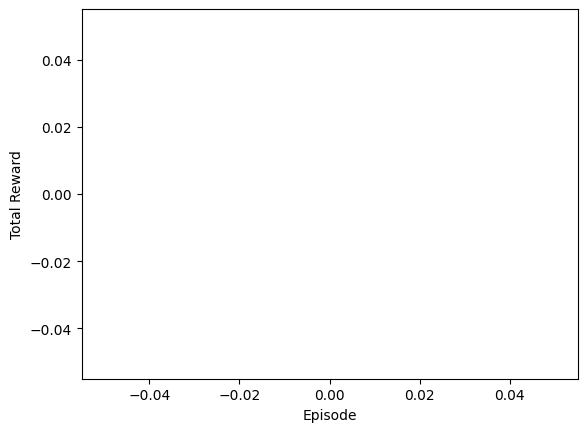

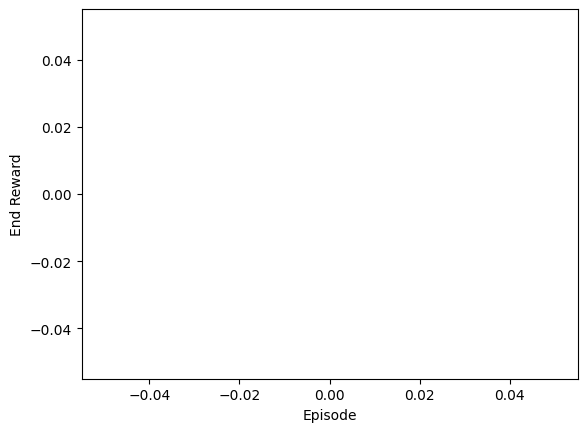

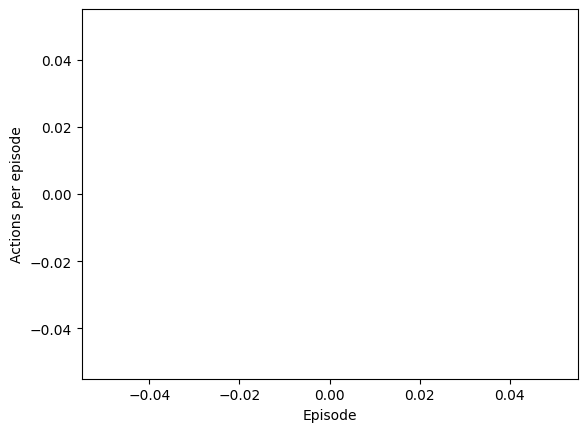

In [17]:
# Plot the rewards
total_rewards_rolling = [np.mean(total_rewards[max(0, i-100):i+1]) for i in range(len(total_rewards))]
plt.plot(total_rewards_rolling)
#Plot the 100 episode rolling average
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# plot the end rewards
end_rewards_rolling = [np.mean(end_rewards[max(0, i-100):i+1]) for i in range(len(end_rewards))]
plt.figure()
plt.plot(end_rewards_rolling)
plt.xlabel('Episode')
plt.ylabel('End Reward')

# plot the end rewards
num_actions_per_episode_rolling = [np.mean(num_actions_per_episode[max(0, i-100):i+1]) for i in range(len(num_actions_per_episode))]
plt.figure()
plt.plot(num_actions_per_episode_rolling)
plt.xlabel('Episode')
plt.ylabel('Actions per episode')

# Visualize agent


In [18]:
def visualize_actor_critic_agent(agent, env, n_episodes=5, seed=None):
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset(seed=seed)
        done = False
        score = 0
        max_t = 5000
        t = 0
        while not done:
            env.render()
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = agent.choose_action(state)
            action = action.cpu().numpy()
            print('-----------------')
            print(f'action: {action}')
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            score += reward
            t += 1
            if done or t >= max_t:
                break
        print(f"Episode {i_episode}\tScore: {score}")

        #Final render
        env.render()
    #env.close()

In [19]:
visualize_actor_critic_agent(agent, env,n_episodes=1, seed=42)

Class 1:
Day 1: [-1 -1 -1 -1]
Day 2: [-1 -1 -1 -1]

Fitness: -29.400000000000002, Actions left: 70
Target Hours:
Class 1: [3 4]
-----------------
action: [0 1 3 0]
Class 1:
Day 1: [-1 -1 -1 -1]
Day 2: [-1 -1 -1  0]

Fitness: -25.200000000000003, Actions left: 69
Target Hours:
Class 1: [2 4]
-----------------
action: [0 1 0 0]
Class 1:
Day 1: [-1 -1 -1 -1]
Day 2: [ 0 -1 -1  0]

Fitness: -21.0, Actions left: 68
Target Hours:
Class 1: [1 4]
-----------------
action: [0 0 1 0]
Class 1:
Day 1: [-1  0 -1 -1]
Day 2: [ 0 -1 -1  0]

Fitness: -16.8, Actions left: 67
Target Hours:
Class 1: [0 4]
-----------------
action: [0 0 0 1]
Class 1:
Day 1: [ 1  0 -1 -1]
Day 2: [ 0 -1 -1  0]

Fitness: -12.600000000000001, Actions left: 66
Target Hours:
Class 1: [0 3]
-----------------
action: [0 1 3 0]
Class 1:
Day 1: [ 1  0 -1 -1]
Day 2: [ 0 -1 -1 -1]

Fitness: -16.8, Actions left: 65
Target Hours:
Class 1: [1 3]
-----------------
action: [0 1 3 1]
Class 1:
Day 1: [ 1  0 -1 -1]
Day 2: [ 0 -1 -1  1]

Fitnes